# The Battle of Neighborhoods: Toronto

## Environment & Libraries

In [1]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

from geopy.geocoders import Nominatim # geocoder

import requests # library to handle requests

from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe

import matplotlib.cm as cm # library for plotting
import matplotlib.colors as colors
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans # k-means for clustering stage

import folium # map rendering library

## Data wrangling: Population density & Income levels 

Population density and income levels are uploaded from a local csv file.

In [3]:
df_census = pd.read_csv("https://raw.githubusercontent.com/lida-p/Coursera_Capstone/master/Toronto_census.csv")
df_census.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

For the purpose of my analysis, I am interested in the number of households with incomes greater than or equal to $60,000 and the population density in each neighborhood.

In [4]:
df_census.iloc[[7,1048,1049,1050,1051,1052,1053],:]

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
7,8,Population,Population and dwellings,Census Profile 98-316-X2016001,Population density per square kilometre,"4,334","3,929","3,034","2,435","10,863","2,775","3,377","14,097","4,195","3,240","4,209","3,614","4,011","3,765","6,282","8,134","7,791","1,040","6,764","5,045","8,335","6,464","5,683","2,479","23,044","3,632","3,979","2,273","7,478","8,554","7,881","6,441","4,146","9,819","2,337","8,540","8,038","2,840","7,051","3,306","6,466","2,171","6,582","9,026","8,054","4,380","5,864","8,582","2,673","6,047","11,726","4,893","2,403","3,148","3,981","1,570","3,565","7,682","7,031","2,712","5,442","6,467","4,770","11,806","4,356","3,593","4,697","6,144","3,038","6,407","4,685","3,596","12,859","4,584","4,948","4,012","3,614","2,830","4,915","3,041","14,753","6,442","7,291","5,411","21,969","3,342","3,926","5,070","10,156","6,770","44,321","7,444","9,511","3,780","3,997","9,601","4,691","2,547","8,671","5,273","2,138","16,880","4,229","4,414","9,851","4,500","1,260","6,333","4,734","5,395","9,583","3,136","2,430","5,436","3,199","5,073","15,528","6,058","3,130","6,787","9,570","5,395","3,710","8,943","2,856","1,117","7,339","7,197","7,601","2,724","10,087","5,820","4,007","4,345","7,838","6,722","8,541","7,162","10,708","2,086","2,451"
1048,1049,Income,Income of households in 2015,Census Profile 98-316-X2016001,$60000 to 69999,"76,120",700,645,300,900,885,430,840,655,290,395,200,845,595,565,165,430,95,400,560,420,255,285,230,"1,310",700,480,350,370,2

I create a list of neighborhood names that will be used to fetch their latitude and longitude and check the first five.

In [13]:
names = list(df_census.columns[6:])
names[0:5]

['Agincourt North',
 'Agincourt South-Malvern West',
 'Alderwood',
 'Annex',
 'Banbury-Don Mills']

To get the total number of households with income of $60,000, I transform the corresponding cell values into integers and create a new dataframe with the sum for each neighborhood.

In [14]:
for name in names:
    df_census.loc[1048:1053, name] = df_census.loc[1048:1053, name].str.replace(",", "").astype(int)
income_60k = df_census.loc[1048:1053, names].sum().astype(int)

## Data wrangling: Geographical coordinates of neighborhoods

I use the Nominatim geocoding service of GeoPy to extract geographical coordinates of each neighborhood, combined with the data from df_census and income_60k to create a new dataframe that includes all the necessary information.

In [15]:
geolocator = Nominatim(user_agent = 'toronto', timeout=50)
df = pd.DataFrame(columns=["Neighborhood", "Households with income $60,000 and over", "Population density per square km", "Latitude", "Longitude"])

for address in names:
    location = geolocator.geocode(address +', Toronto, ON, Canada')
    if location:
        df= df.append({
            "Neighborhood": address, 
            "Households with income $60,000 and over": income_60k[address],
            "Population density per square km": df_census.loc[7, address], 
            "Latitude": location.latitude, 
            "Longitude": location.longitude
        }, ignore_index=True) # I ensure that only the neighborhoods with assigned geolocations are included in the new df
df.set_index("Neighborhood", inplace=True)

In [16]:
df.head()

,"Households with income $60,000 and over",Population density per square km,Latitude,Longitude
Neighborhood,,,,
Agincourt North,5205,"3,929",43.808038,-79.266439
Agincourt South-Malvern West,4470,"3,034",43.798529,-79.262250
Alderwood,3420,"2,435",43.601717,-79.545232
Annex,11580,"10,863",43.670338,-79.407117
Banbury-Don Mills,9290,"2,775",43.734804,-79.357243


Cell values of "Population density per square km" column need to be transformed into integers, as well.

In [17]:
df["Population density per square km"] = df["Population density per square km"].str.replace(",", "").astype(int)

In [18]:
df.head()

,"Households with income $60,000 and over",Population density per square km,Latitude,Longitude
Neighborhood,,,,
Agincourt North,5205,3929,43.808038,-79.266439
Agincourt South-Malvern West,4470,3034,43.798529,-79.262250
Alderwood,3420,2435,43.601717,-79.545232
Annex,11580,10863,43.670338,-79.407117
Banbury-Don Mills,9290,2775,43.734804,-79.357243


## Exploratory analysis & data visualisation

I want to identify top 10 neighborhoods, first by higher income households and then by population density.

In [19]:
df_sorted = df.sort_values(['Households with income $60,000 and over','Population density per square km'], ascending=[False, False]).head(10)
df_sorted

,"Households with income $60,000 and over",Population density per square km,Latitude,Longitude
Neighborhood,,,,
Niagara,13660,10156,43.643470,-79.408248
Islington-City Centre West,13185,2712,43.648795,-79.549000
Willowdale East,13095,10087,43.761510,-79.410923
Annex,11580,10863,43.670338,-79.407117
Rouge,10800,1260,43.804930,-79.165837
Church-Yonge Corridor,10465,23044,43.679919,-79.388689
Rosedale-Moore Park,10215,4500,43.690388,-79.383297
Mount Pleasant West,10090,21969,43.703929,-79.388200
Banbury-Don Mills,9290,2775,43.734804,-79.357243


Before  icreate a bar chart to visualize my data, I need to drop any unecessary columns.

In [20]:
# drop columns
df_sorted_top = df_sorted.drop(['Latitude', 'Longitude'], axis=1, inplace=False)
df_sorted_top

,"Households with income $60,000 and over",Population density per square km
Neighborhood,,
Niagara,13660,10156
Islington-City Centre West,13185,2712
Willowdale East,13095,10087
Annex,11580,10863
Rouge,10800,1260
Church-Yonge Corridor,10465,23044
Rosedale-Moore Park,10215,4500
Mount Pleasant West,10090,21969
Banbury-Don Mills,9290,2775


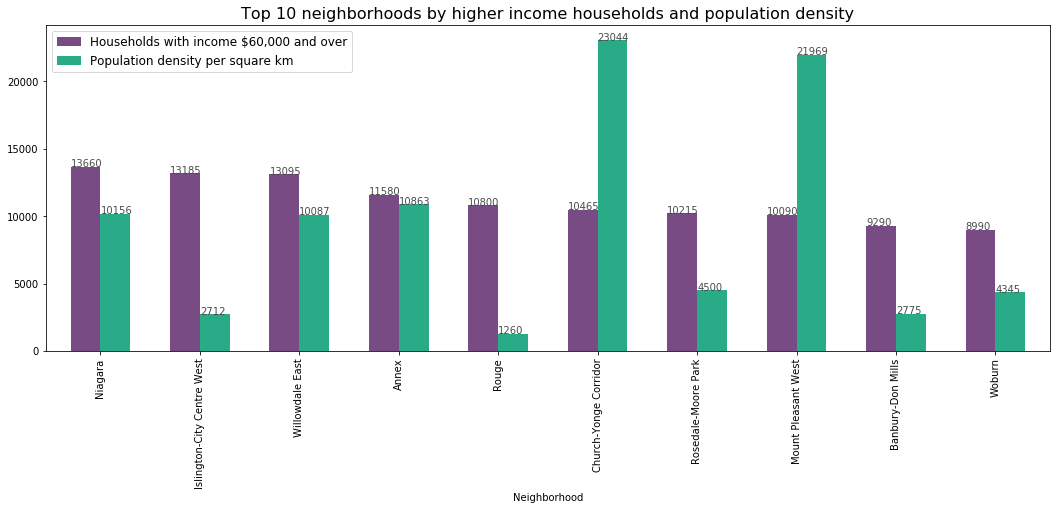

In [21]:
# visualise data
colors_list = ['#784b84','#29ab87']
ax=df_sorted_top.plot(kind='bar', figsize=(18,6), width = 0.6, color=colors_list, edgecolor=None)

ax.set_title("Top 10 neighborhoods by higher income households and population density", fontsize=16)
ax.legend(labels=df.columns, fontsize=12)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar labels using above list
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), \
            str(i.get_height()), fontsize=10,
                color='#48494b')

Based on the graph above Church-Younge Corridor and Mount Pleasant West could be potentially good locations, as the number of higher income households do not differ a lot, whereas their population density per square km is much higher compared to the rest of the neighborhoods.

## Map visualisation

I create a map with the top 10 neighborhoods superimposed, by first getting the coordinates of Toronto and converting the 'Neighborhood' index into a column.

In [22]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [23]:
df_sorted.reset_index(inplace=True)

In [37]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_sorted['Latitude'], df_sorted['Longitude'], df_sorted['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], 
                        radius=5, 
                        popup=label, 
                        color='yellow', 
                        fill=True, 
                        fill_color='#f0e630', 
                        fill_opacity=0.7, 
                        parse_html=False).add_to(map_toronto)  

map_toronto

Based on the map above, I choose to focus on Mount Pleasant West, Rosedale - Moore Park, Church - Yonge Corridor, and Annex, as customers may be drawn from any of these neighborhoods due to their proximity with on another.

In [31]:
df_sorted_focused = df_sorted.iloc[[3,5,6,7],:]
df_sorted_focused

,Neighborhood,"Households with income $60,000 and over",Population density per square km,Latitude,Longitude
3,Annex,11580,10863,43.670338,-79.407117
5,Church-Yonge Corridor,10465,23044,43.679919,-79.388689
6,Rosedale-Moore Park,10215,4500,43.690388,-79.383297
7,Mount Pleasant West,10090,21969,43.703929,-79.388200


## Leveraging Foursquare location data

I utilise the Foursquare API and create a function identifying top 500 venues of each neighborhood within a 1-km radius.

In [26]:
# Define credentials and version
CLIENT_ID = '2ZDVETLSRV3VQTBKHCPHTSQAIXVKQEPFVIQHMZW4T1XN5NIF' 
CLIENT_SECRET = 'FZPK0V2O43WYMC5BQYYNZRPWGWDTWRFSKBDC1VKYCJ1JJFNR' 
VERSION = '20180605' 

# define distance from current location and limit results
radius = 1000
LIMIT = 500

# define URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=2ZDVETLSRV3VQTBKHCPHTSQAIXVKQEPFVIQHMZW4T1XN5NIF&client_secret=FZPK0V2O43WYMC5BQYYNZRPWGWDTWRFSKBDC1VKYCJ1JJFNR&ll=43.653963,-79.387207&v=20180605&radius=1000&limit=500'

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
nearby_venues = getNearbyVenues(names=df_sorted_focused['Neighborhood'],
                                   latitudes=df_sorted_focused['Latitude'],
                                   longitudes=df_sorted_focused['Longitude'])
nearby_venues.head()

Annex
Church-Yonge Corridor
Rosedale-Moore Park
Mount Pleasant West


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annex,43.670338,-79.407117,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant
1,Annex,43.670338,-79.407117,Fresh on Bloor,43.666755,-79.403491,Vegetarian / Vegan Restaurant
2,Annex,43.670338,-79.407117,Fuwa Fuwa Japanese Pancakes,43.665880,-79.407840,Pastry Shop
3,Annex,43.670338,-79.407117,BMV Books,43.665860,-79.406824,Bookstore
4,Annex,43.670338,-79.407117,Hot Docs Ted Rogers Cinema,43.665499,-79.410313,Indie Movie Theater


In [34]:
nearby_venues_gr = nearby_venues[nearby_venues['Venue Category'] == 'Greek Restaurant']
nearby_venues_gr.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
15,Annex,43.670338,-79.407117,The Original Gyro Grill,43.666621,-79.405544,Greek Restaurant
136,Church-Yonge Corridor,43.679919,-79.388689,Fat Lamb Kouzina,43.672290,-79.387660,Greek Restaurant
315,Mount Pleasant West,43.703929,-79.388200,souvlaki express,43.707378,-79.389848,Greek Restaurant


There are only 3 Greek restaurants in the selected neighborhoods, suggesting that potentially Rosedale-Moore Park is a good location from a competition perspective. Due to their limited number though, I choose to expand my search by including other Meditarranean cuisines.

In [35]:
nearby_mediterranean = nearby_venues[nearby_venues['Venue Category'].isin(['Italian Restaurant','Greek Restaurant', 'Spanish Restaurant'])]
nearby_mediterranean_grouped = nearby_mediterranean.groupby('Neighborhood').count().drop(['Neighborhood Latitude', 'Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], axis=1, inplace=False).sort_values('Venue', ascending=False)
nearby_mediterranean_grouped.rename(columns={'Venue':'Number of Mediterranean restaurants'}, inplace=True)
nearby_mediterranean_grouped

,Number of Mediterranean restaurants
Neighborhood,
Church-Yonge Corridor,12
Mount Pleasant West,7
Annex,5
Rosedale-Moore Park,4


## Final analysis

I combine all relevant information into a single dataframe to conclude my analysis in the report.

In [36]:
df_sorted_focused.set_index('Neighborhood').join(nearby_mediterranean_grouped).drop(['Latitude', 'Longitude'], axis=1, inplace=False)

,"Households with income $60,000 and over",Population density per square km,Number of Mediterranean restaurants
Neighborhood,,,
Annex,11580,10863,5
Church-Yonge Corridor,10465,23044,12
Rosedale-Moore Park,10215,4500,4
Mount Pleasant West,10090,21969,7
